# Mask Refine Demo

## Set Up & Configuration

First, we'll import the generally required packages:

In [1]:
# external packages
import cv2
import imgaug.augmenters as iaa
import numpy as np
from os.path import exists

# internal packages
from mask_refine.mask_refine import MaskRefineSubnet
from opt_flow.opt_flow import TensorFlowPWCNet
from train.davis2017_dataset import *
from train.datautils import splitd
from train.viz import *

Using TensorFlow backend.


Now, we'll need to define some useful constants and parameters. (Change these to the appropriate numbers for your system and application.)

We're also creating the dataset and the generator here.

The generator creates masks for inputs by augmenting them in certain ways. The list of specific augmentations is in the code (see definition for AUGMENTATION_SEQUENCE). These are designed to both give a
variety of valid inputs to the mask refine model and to mimic the masks that are produced by mask r-cnn (which will supply the actual masks in the full pipeline).

In [2]:
# paths -- make sure these are set to the correct locations on your system
DATASET_PATH = '../data/DAVIS/'
OPTICAL_FLOW_WEIGHTS = './opt_flow/models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000'
MASK_REFINE_WEIGHTS = './logs/davis_unet_weights__30__0.10.h5'

# make sure the paths exist before going too far 
assert exists(DATASET_PATH), 'Can\'t find path for dataset'
# we don't check the optical flow one, since that is only a 'virtual path' of sorts
assert exists(MASK_REFINE_WEIGHTS), 'Can\'t find path for mask refine model'

# sequence of augmentations applied to the ground truth mask to transform it into an input mask
AUGMENTATION_SEQUENCE = iaa.Sequential([
    iaa.Multiply((0.25, 0.95)),
    iaa.ElasticTransformation(alpha=(2000, 10000), sigma=(20, 100)),
    iaa.GaussianBlur(sigma=(0, 20)),
    iaa.Sometimes(0.25, iaa.Multiply((0.5, 0.75))),
    iaa.MultiplyElementwise((0.8, 1.1)),
    iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(5, 100))),
    iaa.AdditiveGaussianNoise(scale=(1, 25))
])

# let's create the dataset and the generator (which takes in the sequence of augmentations as input)
DATASET = get_trainval(DATASET_PATH)
IMAGE_SHAPE = DATASET.size
GENERATOR = DATASET.paired_generator(AUGMENTATION_SEQUENCE)

Now, we create the optical flow model, the mask refine subnet, and the overall mask refine module.

In [3]:
# first we build the optical flow network
pwc_net = TensorFlowPWCNet(IMAGE_SHAPE, model_pathname=OPTICAL_FLOW_WEIGHTS, verbose=True)

# the 'subnet' is the U-Net only portion of the module
mr_subnet = MaskRefineSubnet(pwc_net)
mr_subnet.load_weights(MASK_REFINE_WEIGHTS)

Building model...
... model built.
Loading model checkpoint ./opt_flow/models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000 for eval or testing...

INFO:tensorflow:Restoring parameters from ./opt_flow/models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000
... model loaded

Model Configuration:
  verbose                True
  ckpt_path              ./opt_flow/models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000
  x_dtype                <dtype: 'float32'>
  x_shape                [2, None, None, 3]
  y_dtype                <dtype: 'float32'>
  y_shape                [None, None, 2]
  gpu_devices            ['/device:GPU:0']
  controller             /device:GPU:0
  batch_size             1
  use_tf_data            True
  use_mixed_precision    False
  pyr_lvls               6
  flow_pred_lvl          2
  search_range           4
  use_dense_cx           True
  use_res_cx             True
  adapt_info             (1, 480, 854, 2)
  mode              

## Inference (on Random Image Pairs)

The following code snippet will run prediction and evaluation for a random image from the dataset.

In [18]:
# get a random set of inputs and ground truth mask
prev_image, curr_image, input_mask, gt_mask = next(GENERATOR)

# get a prediction and an evaluation (list of metrics) from running the full module
pred_mask = mr_subnet.predict(prev_image, curr_image, input_mask)
pred_metrics = mr_subnet.evaluate(prev_image, curr_image, input_mask, gt_mask)

# print the evaluation metrics for this image pair + mask
print(f'\nOUTPUT RESULTS:')
for metric, val in zip(mr_subnet.metrics, pred_metrics):
    print(f'\t{metric}:\t{val}')
    
# define the images/masks to be displayed
disp_prev_image = prev_image[0, ...]
disp_curr_image = curr_image[0, ...]
trans_mask = input_mask[0, ...].astype(int)
pred_mask = pred_mask[0, ...].astype(float)
gt_mask = gt_mask[..., 0].astype(int)

1/1 [==============================] - 27s 27s/step

OUTPUT RESULTS:
	loss:	0.10934434086084366
	binary_accuracy:	0.9652165174484253
	binary_crossentropy:	0.10934434086084366


We'll also get the flow field, so we can display that as well.

In [1]:
# get just the flow field, so that we can display it as an intermediary input
with model_graph.as_default():
    of = pwc_net.infer_from_image_stack(np.concatenate([prev_image, curr_image], axis=2))
    
# in order to visualize the flow field (which has 2 channels), we convert the field's
# vectors from Cartesian to polar.
# 
# Represented as HSV, the angle of the vector is the hue, and the magnitude is the value.
# The images use full (255) saturation.
hsv = np.zeros(curr_image.shape, dtype=np.uint8)
hsv[..., 1] = 255

mag, ang = cv2.cartToPolar(of[..., 0], of[..., 1])
hsv[..., 0] = ang * 180 / np.pi / 2
hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
of_polar = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

NameError: name 'model_graph' is not defined

### Visualizations

Let's visualize what the inputs and outputs look like (as images).

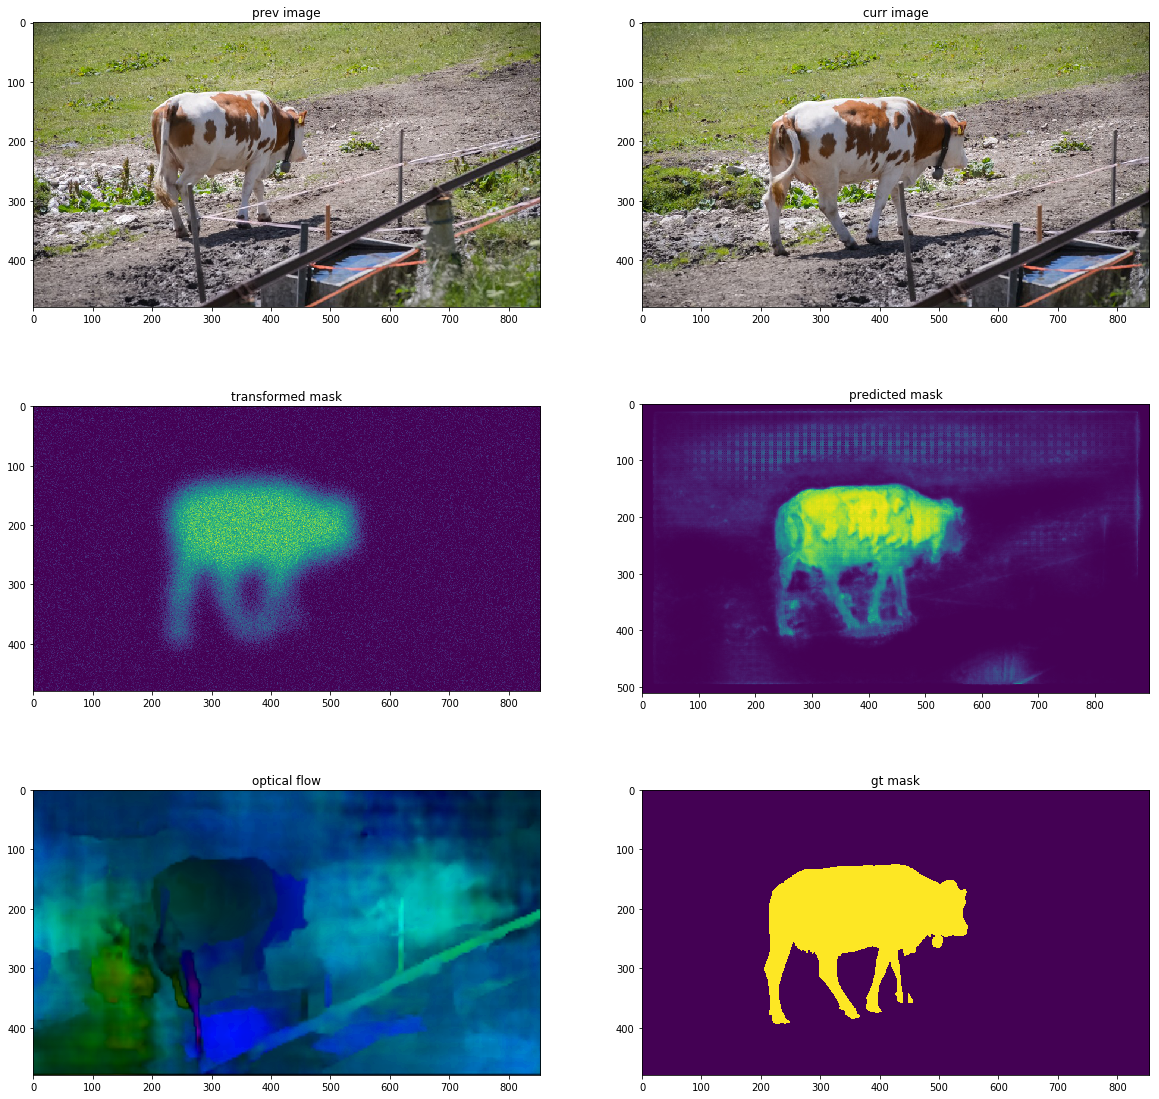

In [20]:
# where to save the image of the figure
fig_save_path = './mask_refine/example.png'

# visualize and plot the inputs, intermediate inputs, and outputs (both predicted and ground truth)
vis_fix_col(prev_image, curr_image,
            trans_mask, pred_mask,
            of_polar, gt_mask,
            titles=['prev image', 'curr image',
                    'transformed mask', 'predicted mask',
                    'optical flow', 'gt mask'],
            figsize=(20, 20),
            save_path=fig_save_path)